# 使用AkShare和Backtrader实现双均线策略回测教程

本教程将详细介绍如何：
1. 使用AkShare获取真实股票历史数据
2. 利用Backtrader框架实现最简单的双均线策略回测
3. 可视化回测结果
4. 对每一步代码进行详细解释，适合初学者学习量化回测流程。

## 1. 安装所需库

本教程需要用到 `akshare` 和 `backtrader`，如未安装请先运行下方代码安装。

In [1]:
# !pip install akshare backtrader matplotlib
# 若在国内建议加速镜像：
# !pip install akshare backtrader matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple

## 2. 获取真实股票数据（以贵州茅台为例）

我们使用AkShare获取贵州茅台（600519.SH）的日线历史数据。

In [2]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
# 设置Jupyter Notebook的中文显示

plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号


# 获取贵州茅台日线数据
stock_df = ak.stock_zh_a_hist(symbol='600519', period='daily', start_date='20230630', end_date='20250630', adjust='qfq')
# 查看前几行数据
stock_df.head()

C:\Users\Jinze Wang\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2023-06-30,600519,1598.54,1589.54,1607.53,1585.02,20459,3.472587e+09,1.42,0.20,3.20,0.16
1,2023-07-03,600519,1597.54,1622.64,1623.82,1590.54,19139,3.286738e+09,2.09,2.08,33.10,0.15
2,2023-07-04,600519,1622.74,1629.14,1632.98,1616.62,12472,2.155554e+09,1.01,0.40,6.50,0.10
3,2023-07-05,600519,1628.54,1613.92,1630.51,1598.54,14745,2.523961e+09,1.96,-0.93,-15.22,0.12
4,2023-07-06,600519,1607.70,1601.52,1631.54,1598.54,15141,2.589459e+09,2.04,-0.77,-12.40,0.12


## 3. 数据预处理

Backtrader需要特定格式的数据，这里我们将AkShare获取的数据整理为Backtrader可用格式。

In [3]:
# 只保留Backtrader需要的字段，并重命名
data = stock_df[['日期', '开盘', '收盘', '最高', '最低', '成交量']]
data.columns = ['datetime', 'open', 'close', 'high', 'low', 'volume']
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data = data.sort_index()
data.head()

C:\Users\Jinze Wang\AppData\Local\Temp\ipykernel_24332\616020753.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = pd.to_datetime(data['datetime'])


,open,close,high,low,volume
datetime,,,,,
2023-06-30,1598.54,1589.54,1607.53,1585.02,20459
2023-07-03,1597.54,1622.64,1623.82,1590.54,19139
2023-07-04,1622.74,1629.14,1632.98,1616.62,12472
2023-07-05,1628.54,1613.92,1630.51,1598.54,14745
2023-07-06,1607.70,1601.52,1631.54,1598.54,15141


## 4. 定义双均线策略

双均线策略是最经典的量化策略之一：
- 当短期均线上穿长期均线时买入
- 当短期均线下穿长期均线时卖出

下面用Backtrader实现该策略。

In [4]:
import backtrader as bt

class MAStrategy(bt.Strategy):
    def __init__(self):
        self.ma_fast = bt.indicators.SimpleMovingAverage(self.datas[0].close, period=3)
        self.ma_slow = bt.indicators.SimpleMovingAverage(self.datas[0].close, period=10)
    def next(self):
        if not self.position:  # 没有持仓
            if self.ma_fast[0] > self.ma_slow[0] and self.ma_fast[-1] <= self.ma_slow[-1]:
                self.buy()  # 金叉买入
        else:  # 已有持仓
            if self.ma_fast[0] < self.ma_slow[0] and self.ma_fast[-1] >= self.ma_slow[-1]:
                self.sell()  # 死叉卖出

## 5. 回测准备与运行

将整理好的数据导入Backtrader，运行回测。

In [5]:
cerebro = bt.Cerebro()
cerebro.addstrategy(MAStrategy)

# 将pandas数据转为Backtrader数据格式
datafeed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(datafeed)

cerebro.broker.setcash(1000000)  # 初始资金100万
print('初始资金: %.2f' % cerebro.broker.getvalue())

result = cerebro.run()
print('回测结束资金: %.2f' % cerebro.broker.getvalue())

初始资金: 1000000.00
回测结束资金: 1000018.17


In [6]:
class RSIStrategy(bt.Strategy):
    params = (
        ('rsi_period', 14),      # RSI周期
        ('oversold', 30),        # 超卖阈值
        ('overbought', 70),      # 超买阈值
    )
    
    def __init__(self):
        self.rsi = bt.indicators.RSI(self.datas[0].close, period=self.params.rsi_period)
        self.order = None
        
    def next(self):
        if self.order:
            return
            
        if not self.position:  # 没有持仓
            if self.rsi[0] < self.params.oversold:  # RSI超卖，买入信号
                self.order = self.buy()
        else:  # 已有持仓
            if self.rsi[0] > self.params.overbought:  # RSI超买，卖出信号
                self.order = self.sell()

In [ ]:
# 输出每次买入和卖出点、价格和数量
trades = []

class MAStrategyWithLog(bt.Strategy):
    params = (
        ('fast_period', 2),('slow_period', 20), )
    def __init__(self):
        self.ma_fast = bt.indicators.SimpleMovingAverage(self.datas[0].close, period=2)
        self.ma_slow = bt.indicators.SimpleMovingAverage(self.datas[0].close, period=20)
    def next(self):
        if not self.position:  # 没有持仓
            if self.ma_fast[0] > self.ma_slow[0] and self.ma_fast[-1] <= self.ma_slow[-1]:
                order = self.buy()  # 金叉买入
                trades.append({
                    'datetime': self.datas[0].datetime.date(0),
                    'type': '买入',
                    'price': self.datas[0].close[0],
                    'size': self.broker.get_cash() // self.datas[0].close[0]
                })
        else:  # 已有持仓
            if self.ma_fast[0] < self.ma_slow[0] and self.ma_fast[-1] >= self.ma_slow[-1]:
                order = self.sell()  # 死叉卖出
                trades.append({
                    'datetime': self.datas[0].datetime.date(0),
                    'type': '卖出',
                    'price': self.datas[0].close[0],
                    'size': self.position.size
                })


In [10]:

# 用带日志的策略重新回测
cerebro_log = bt.Cerebro()
cerebro_log.addstrategy(RSIStrategy)
datafeed_log = bt.feeds.PandasData(dataname=data)
cerebro_log.adddata(datafeed_log)
cerebro_log.broker.setcash(1000000)
cerebro_log.run()



In [11]:
# 输出最终的买卖点、价格和数量
print(f"最终买卖点: {trades[-1]}")
print(f"最终价格: {trades[-1]['price']}")
print(f"最终数量: {trades[-1]['size']}")

最终买卖点: {'datetime': datetime.date(2025, 5, 23), 'type': '卖出', 'price': 1545.0, 'size': 1}
最终价格: 1545.0
最终数量: 1


In [12]:
# 输出RSI策略的买卖点和最终资产

# 输出RSI策略的买卖点明细
import pandas as pd
trades_df = pd.DataFrame(trades)
if not trades_df.empty:
    print("RSI策略买卖点明细：")
    print(trades_df[['datetime', 'type', 'price', 'size']])
else:
    print("本次回测无买卖点。")

# 输出最终资产
final_value = cerebro_log.broker.getvalue()
print(f"RSI策略最终资产：{final_value:.2f} 元")


RSI策略买卖点明细：
      datetime type    price   size
0   2023-08-29   买入  1749.87  571.0
1   2023-09-11   卖出  1720.71    1.0
2   2023-09-25   买入  1730.92  577.0
3   2023-09-26   卖出  1714.54    1.0
4   2023-11-01   买入  1679.53  595.0
5   2023-11-27   卖出  1661.54    1.0
6   2023-11-30   买入  1690.04  591.0
7   2023-12-01   卖出  1658.82    1.0
8   2023-12-28   买入  1642.63  608.0
9   2024-01-05   卖出  1581.00    1.0
10  2024-01-29   买入  1567.64  637.0
11  2024-01-30   卖出  1530.64    1.0
12  2024-02-06   买入  1593.64  627.0
13  2024-03-08   卖出  1589.07    1.0
14  2024-03-12   买入  1662.64  601.0
15  2024-03-25   卖出  1606.65    1.0
16  2024-03-27   买入  1618.64  617.0
17  2024-03-28   卖出  1619.28    1.0
18  2024-04-01   买入  1638.97  609.0
19  2024-04-08   卖出  1584.30    1.0
20  2024-04-23   买入  1609.92  620.0
21  2024-05-15   卖出  1617.64    1.0
22  2024-05-17   买入  1632.64  612.0
23  2024-05-21   卖出  1622.64    1.0
24  2024-07-15   买入  1423.42  702.0
25  2024-07-24   卖出  1388.54    1.0
26  2024-08-16  

In [ ]:
# 输出买卖点
import pandas as pd
trades_df = pd.DataFrame(trades)
if not trades_df.empty:
    print("买卖点明细：")
    print(trades_df[['datetime', 'type', 'price', 'size']])
else:
    print("本次回测无买卖点。")

## 6. 可视化回测结果

Backtrader自带可视化功能，可以直接画出策略买卖点和资金曲线。

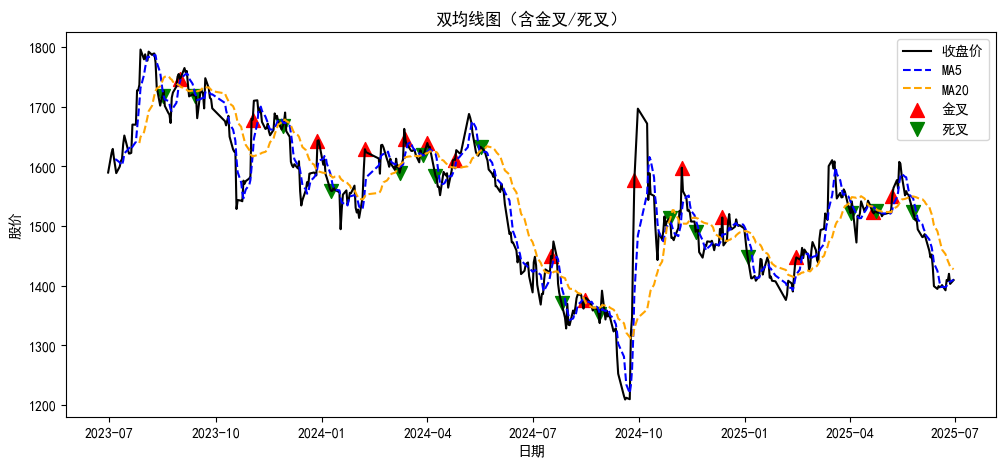

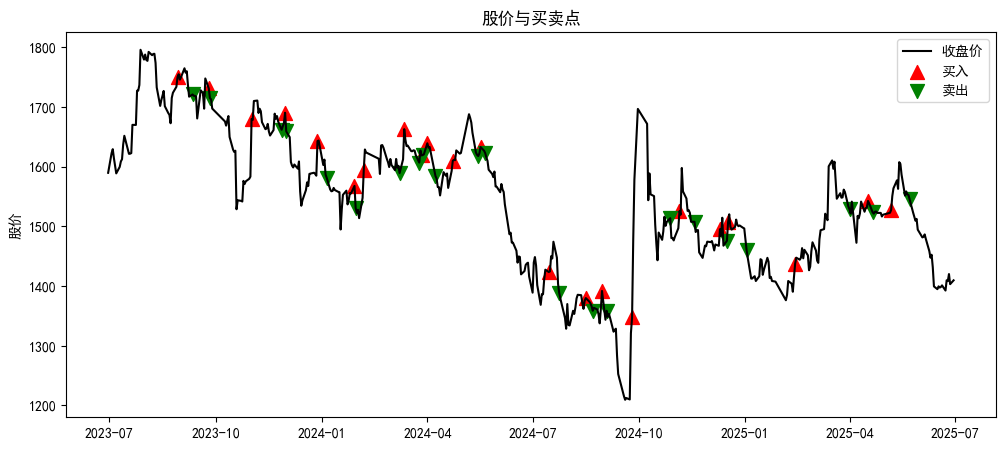

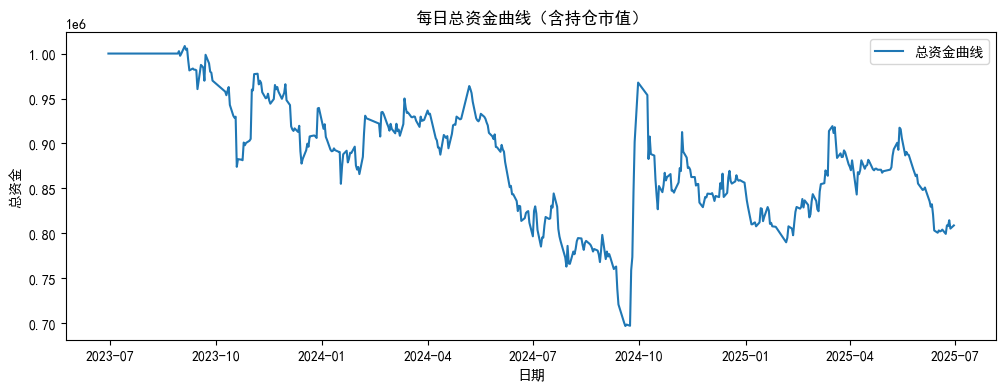

In [7]:
import matplotlib.pyplot as plt

# 1. 绘制双均线图
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['close'], label='收盘价', color='black')
ma5 = data['close'].rolling(window=5).mean()
ma20 = data['close'].rolling(window=20).mean()
plt.plot(data.index, ma5, label='MA5', color='blue', linestyle='--')
plt.plot(data.index, ma20, label='MA20', color='orange', linestyle='--')

# 计算金叉和死叉点
golden_cross = (ma5 > ma20) & (ma5.shift(1) <= ma20.shift(1))
death_cross = (ma5 < ma20) & (ma5.shift(1) >= ma20.shift(1))

# 标记金叉
plt.scatter(data.index[golden_cross], data['close'][golden_cross], marker='^', color='red', s=100, label='金叉')
# 标记死叉
plt.scatter(data.index[death_cross], data['close'][death_cross], marker='v', color='green', s=100, label='死叉')

plt.title('双均线图（含金叉/死叉）')
plt.xlabel('日期')
plt.ylabel('股价')
plt.legend()
plt.show()

# 2. 绘制股价+买卖点
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(data.index, data['close'], label='收盘价', color='black')
ax1.set_ylabel('股价')
ax1.set_title('股价与买卖点')

if not trades_df.empty:
    buy_points = trades_df[trades_df['type'] == '买入']
    sell_points = trades_df[trades_df['type'] == '卖出']
    ax1.scatter(buy_points['datetime'], buy_points['price'], marker='^', color='red', label='买入', s=100)
    ax1.scatter(sell_points['datetime'], sell_points['price'], marker='v', color='green', label='卖出', s=100)

ax1.legend()
plt.show()




# 你的总资金曲线是一条直线，原因很可能是 position 始终为0，说明买入/卖出逻辑没有被触发，或者 trades_df['datetime'] 与 data.index 的格式不一致，导致 today_trades 始终为空。
# 解决方法如下：

init_cash = 1000000
cash = init_cash
position = 0
position_price = 0
total_asset_curve = []

# 确保 trades_df['datetime'] 和 data.index 都是 pd.Timestamp 类型且格式一致
if not trades_df.empty:
    trades_df = trades_df.copy()
    trades_df['datetime'] = pd.to_datetime(trades_df['datetime'])
    # 如果data.index是字符串，转为datetime
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

for date, row in data.iterrows():
    # 注意：date是Timestamp类型，trades_df['datetime']也是Timestamp类型
    today_trades = trades_df[trades_df['datetime'] == date] if not trades_df.empty else pd.DataFrame()
    for _, trade in today_trades.iterrows():
        if trade['type'] == '买入':
            # 假设每次全仓买入
            # position = trade['size']  # 原逻辑
            # cash -= position * trade['price']
            # position_price = trade['price']
            # 更合理的写法如下（假设买入size为1手，或按资金买入最大整数股数）：
            buy_size = trade['size']
            cost = buy_size * trade['price']
            if cash >= cost:
                position += buy_size
                cash -= cost
                position_price = trade['price']
        elif trade['type'] == '卖出':
            sell_size = trade['size']
            # 卖出不能超过持仓
            sell_size = min(sell_size, position)
            cash += sell_size * trade['price']
            position -= sell_size
            if position == 0:
                position_price = 0
    # 每日总资产 = 现金 + 持仓市值
    total_asset = cash + position * row['close']
    total_asset_curve.append(total_asset)

plt.figure(figsize=(12, 4))
plt.plot(data.index, total_asset_curve, label='总资金曲线')
plt.xlabel('日期')
plt.ylabel('总资金')
plt.title('每日总资金曲线（含持仓市值）')
plt.legend()
plt.show()


## 7. 总结

- 本教程演示了如何用AkShare获取A股真实数据，并用Backtrader实现最简单的双均线策略回测。
- 你可以尝试更换股票、调整均线参数，或加入止损止盈等功能，进一步完善策略。
- 推荐结合更多指标和风险管理方法，提升策略实用性。